In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import os
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata
import dandelion as ddl
import sys
sys.path.append('/home/jovyan/NC_study/scanpy/scripts')
from tools import cmp, exportDEres
sc.logging.print_versions()

warnings.filterwarnings('ignore')
os.chdir(os.path.expanduser('/home/jovyan/NC_study/scanpy'))

scanpy==1.5.1 anndata==0.7.4 umap==0.4.6 numpy==1.19.1 scipy==1.5.1 pandas==1.0.5 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.8.2 leidenalg==0.8.1


In [2]:
# read in files
adata_all = sc.read_h5ad('out/adata_combined.h5ad')
adata_all

AnnData object with n_obs × n_vars = 67873 × 828
    obs: 'sampleid', 'patient', 'sampletype', 'age_group', 'gender', 'cohort', 'scrublet_score', 'n_genes', 'percent_mito', 'n_counts', 'bh_pval', 'is_doublet', 'filter_rna', 'batch', 'leiden', '__is_in_cluster__', 'fine_label', 'broad_label', 'leiden_R', 'leiden_label'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'age_group_colors', 'broad_label_colors', 'cohort_colors', 'fine_label_colors', 'gender_colors', 'leiden', 'leiden_R_colors', 'leiden_colors', 'leiden_label_colors', 'neighbors', 'pca', 'sampletype_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

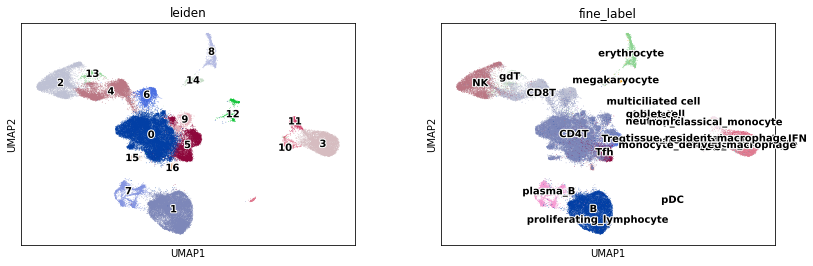

In [3]:
sc.pl.umap(adata_all, color = ['leiden', 'fine_label'], legend_loc = 'on data', legend_fontoutline=2)

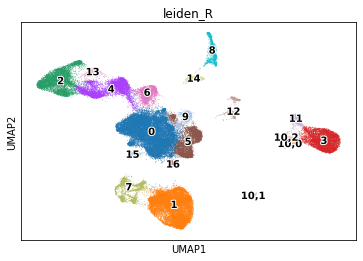

In [4]:
# separate out pDCs
sc.tl.leiden(adata_all, restrict_to = ('leiden', ['10']), resolution = 0.3)
sc.pl.umap(adata_all, color = ['leiden_R'], legend_loc = 'on data', legend_fontoutline=2)

In [5]:
# subset to MNp
adata = adata_all[adata_all.obs['leiden_R'].isin(['3', '10,2', '10,0', '11'])]
adata

View of AnnData object with n_obs × n_vars = 7302 × 828
    obs: 'sampleid', 'patient', 'sampletype', 'age_group', 'gender', 'cohort', 'scrublet_score', 'n_genes', 'percent_mito', 'n_counts', 'bh_pval', 'is_doublet', 'filter_rna', 'batch', 'leiden', '__is_in_cluster__', 'fine_label', 'broad_label', 'leiden_R', 'leiden_label'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'age_group_colors', 'cohort_colors', 'fine_label_colors', 'gender_colors', 'leiden', 'leiden_R_colors', 'leiden_label_colors', 'neighbors', 'pca', 'sampletype_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

... storing 'leiden_label' as categorical


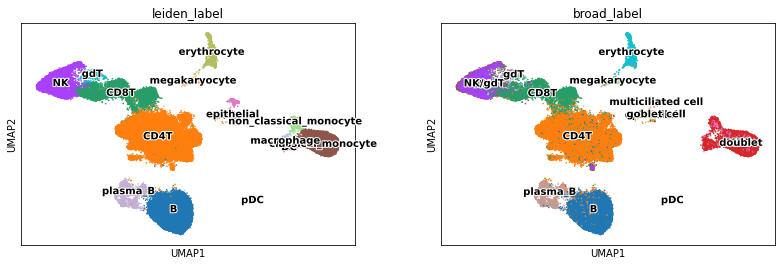

In [6]:
# reassign broad labels
new_dict1 = {'0':'CD4T',
'1':'B',
'2':'NK',
'3':'classical_monocyte',
'4':'CD8T',
'5':'CD4T',
'6':'CD8T',
'7':'plasma_B',
'8':'erythrocyte',
'9':'CD4T',
'10,0':'DC',
'10,1':'pDC',
'10,2':'macrophage',
'11':'non_classical_monocyte',
'12':'epithelial',
'13':'gdT',
'14':'megakaryocyte',
'15':'CD4T',
'16':'CD4T'}
adata_all.obs['leiden_label'] = [new_dict1[l] for l in adata_all.obs['leiden_R']]
sc.pl.umap(adata_all, color=['leiden_label', 'broad_label'], size=10, legend_loc ='on data', legend_fontoutline=2)

In [7]:
# recluster MNPs
adata = sc.AnnData(X = adata.raw.X, obs = adata.obs, var = adata.raw.var, uns = adata.uns, obsm = adata.obsm, obsp = adata.obsp)
adata.raw = adata
adata

AnnData object with n_obs × n_vars = 7302 × 18504
    obs: 'sampleid', 'patient', 'sampletype', 'age_group', 'gender', 'cohort', 'scrublet_score', 'n_genes', 'percent_mito', 'n_counts', 'bh_pval', 'is_doublet', 'filter_rna', 'batch', 'leiden', '__is_in_cluster__', 'fine_label', 'broad_label', 'leiden_R', 'leiden_label'
    uns: 'age_group_colors', 'cohort_colors', 'fine_label_colors', 'gender_colors', 'leiden', 'leiden_R_colors', 'leiden_label_colors', 'neighbors', 'pca', 'sampletype_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

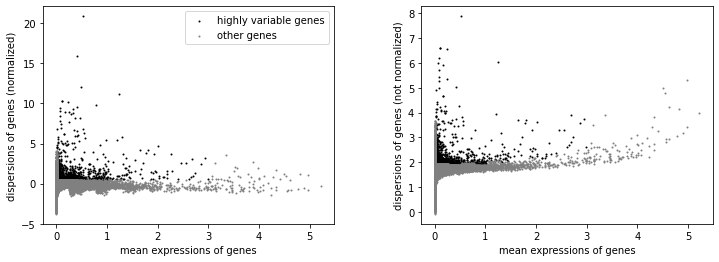

In [8]:
# find highly variable genes
sc.pp.highly_variable_genes(adata, min_mean = 0.0125, max_mean = 3, min_disp = 0.5)
sc.pl.highly_variable_genes(adata)

In [9]:
import multiprocessing
# subset to highly variable
adata = adata[:, adata.var['highly_variable']]
# regress and scale for PCA
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'], n_jobs=multiprocessing.cpu_count()-1)
sc.pp.scale(adata, max_value = 10)

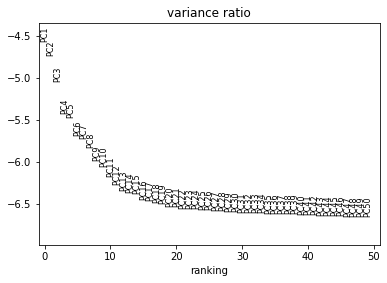

In [10]:
# Principal component analysis
sc.tl.pca(adata, svd_solver = 'arpack')
sc.pl.pca_variance_ratio(adata, log = True, n_pcs = 50)

In [11]:
# run BBKNN
sc.external.pp.bbknn(adata, batch_key = 'patient')

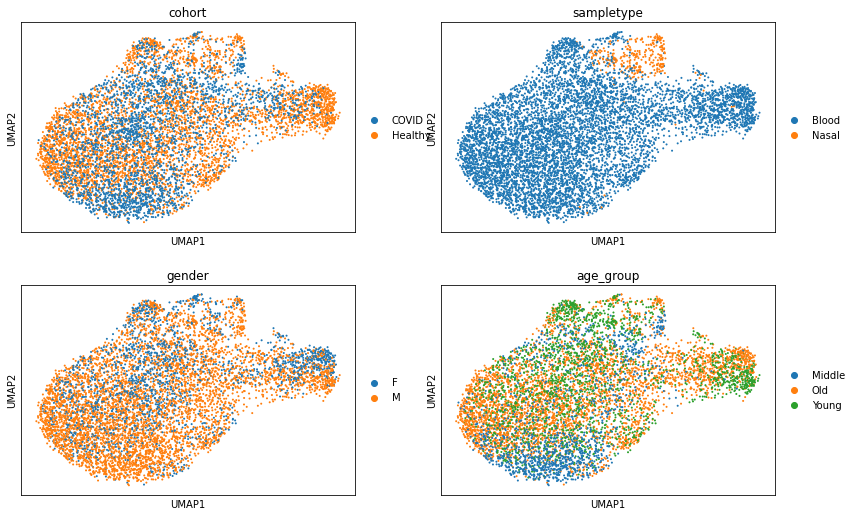

In [12]:
# UMAP
sc.tl.umap(adata, n_components = 2, min_dist = 0.3)
sc.pl.umap(adata, color=['cohort', 'sampletype', 'gender', 'age_group'], ncols =2)

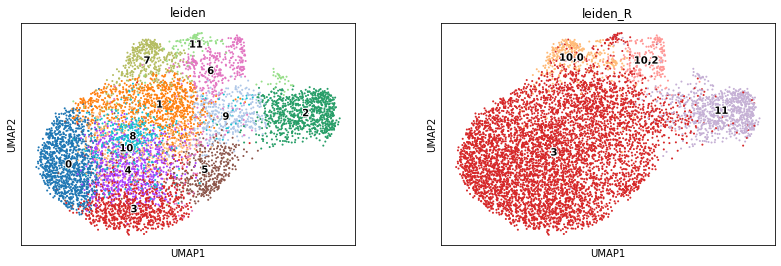

In [13]:
# run clustering
sc.tl.leiden(adata, resolution = 1.5)
sc.pl.umap(adata, color=['leiden', 'leiden_R'], legend_loc = 'on data', legend_fontoutline = 2, color_map = cmp())

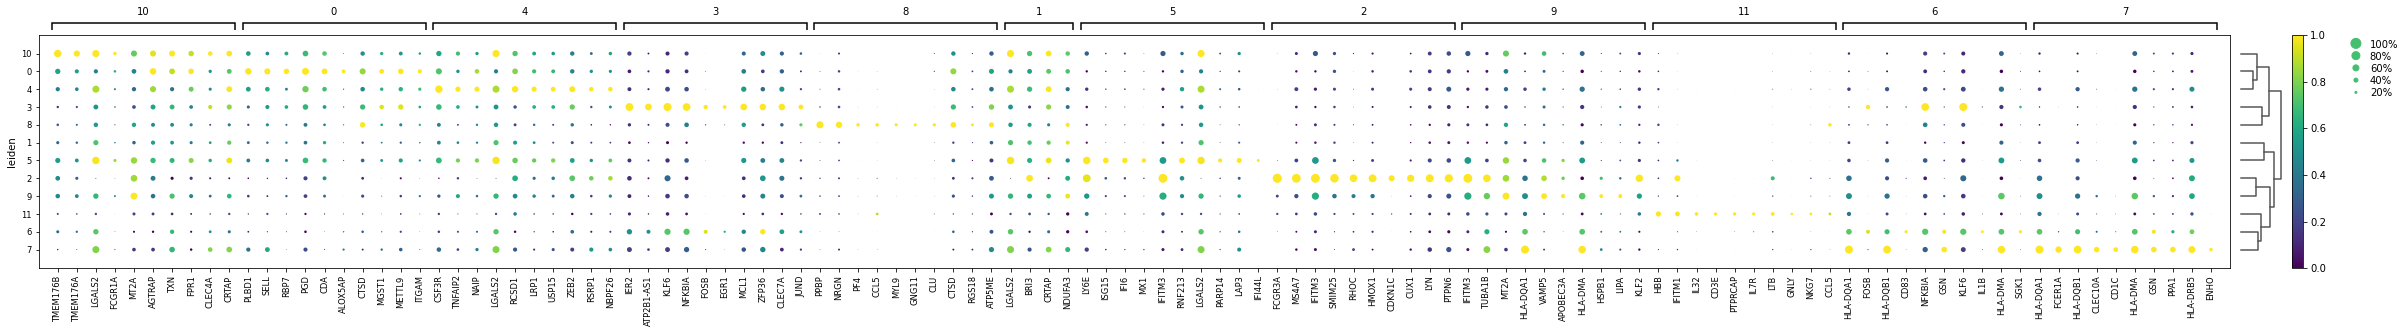

In [14]:
sc.tl.rank_genes_groups(adata, groupby = 'leiden', method = 'wilcoxon')
sc.tl.filter_rank_genes_groups(adata, min_fold_change=1)
sc.tl.dendrogram(adata, groupby = 'leiden')
sc.pl.rank_genes_groups_dotplot(adata, n_genes = 10, standard_scale = 'var', color_map = 'viridis', key = 'rank_genes_groups_filtered')

... storing 'broad_label' as categorical


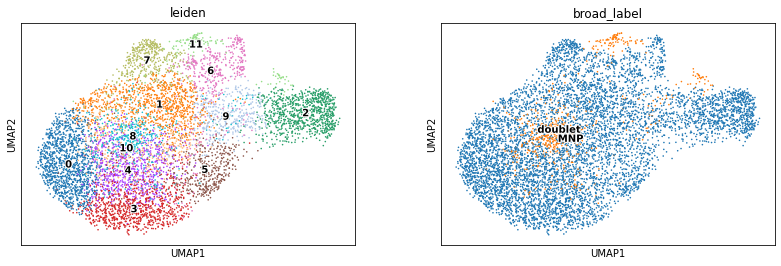

In [15]:
new_dict1 = {'0':'MNP',
'1':'MNP',
'2':'MNP',
'3':'MNP',
'4':'MNP',
'5':'MNP',
'6':'MNP',
'7':'MNP',
'8':'doublet',
'9':'MNP',
'10':'MNP',
'11':'doublet'}
adata.obs['broad_label'] = [new_dict1[l] for l in adata.obs['leiden']]
adata_all.obs['broad_label'] = adata_all.obs['broad_label'].astype('object')
adata_all.obs['broad_label'].update(adata.obs['broad_label'].astype('object'))
sc.pl.umap(adata, color=['leiden', 'broad_label'], size=10, legend_loc ='on data', legend_fontoutline=2)

In [16]:
adata = adata[~(adata.obs['broad_label'] == 'doublet')]
adata

View of AnnData object with n_obs × n_vars = 6736 × 1785
    obs: 'sampleid', 'patient', 'sampletype', 'age_group', 'gender', 'cohort', 'scrublet_score', 'n_genes', 'percent_mito', 'n_counts', 'bh_pval', 'is_doublet', 'filter_rna', 'batch', 'leiden', '__is_in_cluster__', 'fine_label', 'broad_label', 'leiden_R', 'leiden_label'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'age_group_colors', 'cohort_colors', 'fine_label_colors', 'gender_colors', 'leiden', 'leiden_R_colors', 'leiden_label_colors', 'neighbors', 'pca', 'sampletype_colors', 'umap', 'leiden_colors', 'rank_genes_groups', 'rank_genes_groups_filtered', 'dendrogram_leiden', 'broad_label_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [17]:
# recluster filtered MNPs
adata = sc.AnnData(X = adata.raw.X, obs = adata.obs, var = adata.raw.var, uns = adata.uns, obsm = adata.obsm, obsp = adata.obsp)
adata.raw = adata
adata

AnnData object with n_obs × n_vars = 6736 × 18504
    obs: 'sampleid', 'patient', 'sampletype', 'age_group', 'gender', 'cohort', 'scrublet_score', 'n_genes', 'percent_mito', 'n_counts', 'bh_pval', 'is_doublet', 'filter_rna', 'batch', 'leiden', '__is_in_cluster__', 'fine_label', 'broad_label', 'leiden_R', 'leiden_label'
    uns: 'age_group_colors', 'cohort_colors', 'fine_label_colors', 'gender_colors', 'leiden', 'leiden_R_colors', 'leiden_label_colors', 'neighbors', 'pca', 'sampletype_colors', 'umap', 'leiden_colors', 'rank_genes_groups', 'rank_genes_groups_filtered', 'dendrogram_leiden', 'broad_label_colors'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

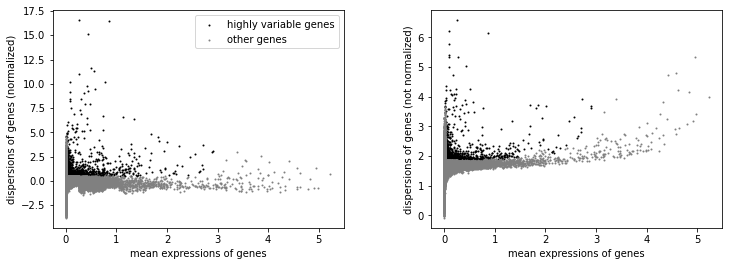

In [18]:
# find highly variable genes
sc.pp.highly_variable_genes(adata, min_mean = 0.0125, max_mean = 3, min_disp = 0.5)
sc.pl.highly_variable_genes(adata)

In [19]:
import multiprocessing
# subset to highly variable
adata = adata[:, adata.var['highly_variable']]
# regress and scale for PCA
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'], n_jobs=multiprocessing.cpu_count()-1)
sc.pp.scale(adata, max_value = 10)

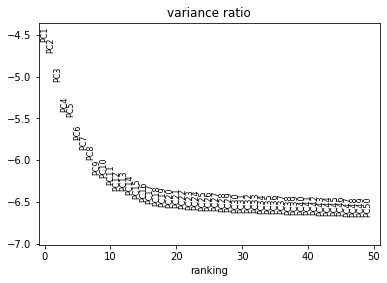

In [20]:
# Principal component analysis
sc.tl.pca(adata, svd_solver = 'arpack')
sc.pl.pca_variance_ratio(adata, log = True, n_pcs = 50)

In [21]:
# run BBKNN
sc.external.pp.bbknn(adata, batch_key = 'patient')

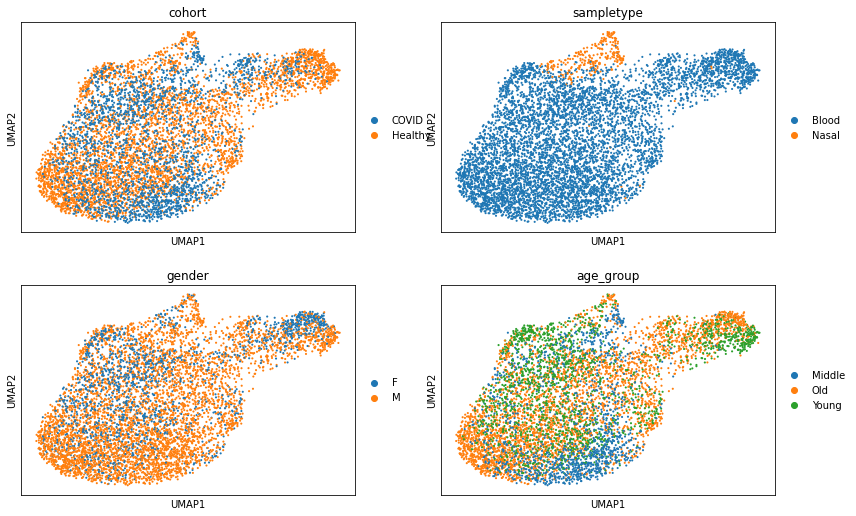

In [22]:
# UMAP
sc.tl.umap(adata, n_components = 2, min_dist = 0.3)
sc.pl.umap(adata, color=['cohort', 'sampletype', 'gender', 'age_group'], ncols =2)

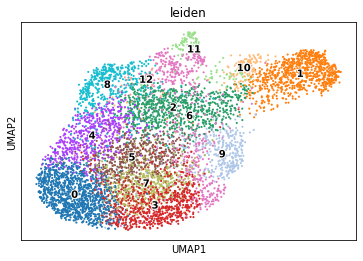

In [23]:
# run clustering
sc.tl.leiden(adata, resolution = 1.5)
sc.pl.umap(adata, color=['leiden'], legend_loc = 'on data', legend_fontoutline = 2, color_map = cmp())

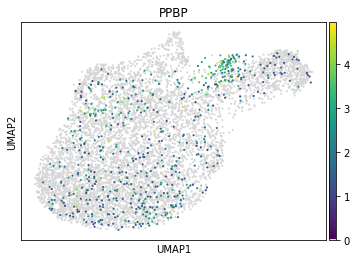

In [24]:
sc.pl.umap(adata, color=['PPBP'], legend_loc = 'on data', legend_fontoutline = 2, color_map = cmp())

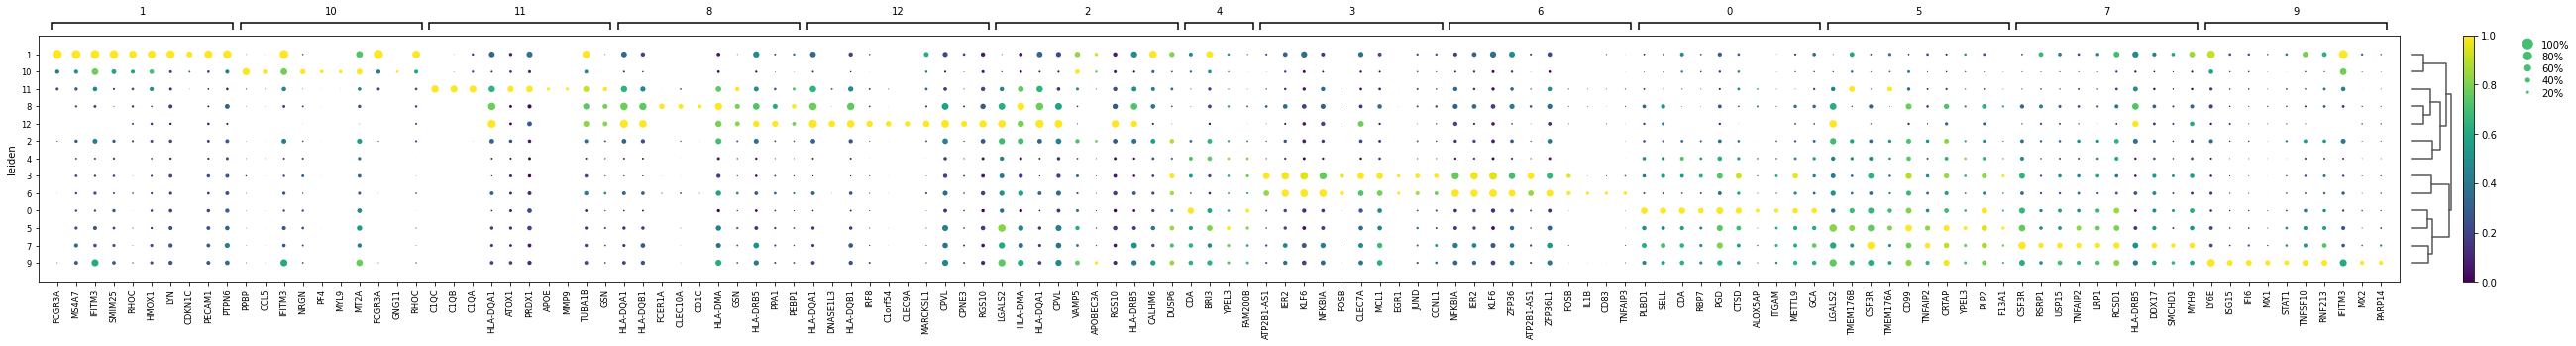

In [25]:
sc.tl.rank_genes_groups(adata, groupby = 'leiden', method = 'wilcoxon')
sc.tl.filter_rank_genes_groups(adata, min_fold_change=1)
sc.tl.dendrogram(adata, groupby = 'leiden')
sc.pl.rank_genes_groups_dotplot(adata, n_genes = 10, standard_scale = 'var', color_map = 'viridis', key = 'rank_genes_groups_filtered')

... storing 'broad_label' as categorical


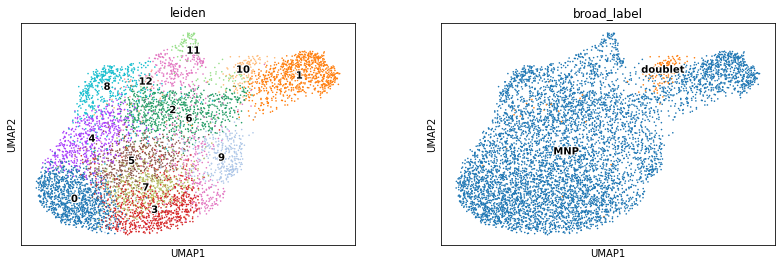

In [26]:
new_dict1 = {'0':'MNP',
'1':'MNP',
'2':'MNP',
'3':'MNP',
'4':'MNP',
'5':'MNP',
'6':'MNP',
'7':'MNP',
'8':'MNP',
'9':'MNP',
'10':'doublet',
'11':'MNP',
'12':'MNP'}
adata.obs['broad_label'] = [new_dict1[l] for l in adata.obs['leiden']]
adata_all.obs['broad_label'] = adata_all.obs['broad_label'].astype('object')
adata_all.obs['broad_label'].update(adata.obs['broad_label'].astype('object'))
sc.pl.umap(adata, color=['leiden', 'broad_label'], size=10, legend_loc ='on data', legend_fontoutline=2)

In [27]:
adata = adata[~(adata.obs['broad_label'] == 'doublet')]
adata

View of AnnData object with n_obs × n_vars = 6595 × 1872
    obs: 'sampleid', 'patient', 'sampletype', 'age_group', 'gender', 'cohort', 'scrublet_score', 'n_genes', 'percent_mito', 'n_counts', 'bh_pval', 'is_doublet', 'filter_rna', 'batch', 'leiden', '__is_in_cluster__', 'fine_label', 'broad_label', 'leiden_R', 'leiden_label'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'age_group_colors', 'cohort_colors', 'fine_label_colors', 'gender_colors', 'leiden', 'leiden_R_colors', 'leiden_label_colors', 'neighbors', 'pca', 'sampletype_colors', 'umap', 'leiden_colors', 'rank_genes_groups', 'rank_genes_groups_filtered', 'dendrogram_leiden', 'broad_label_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [28]:
# recluster filtered MNPs
adata = sc.AnnData(X = adata.raw.X, obs = adata.obs, var = adata.raw.var, uns = adata.uns, obsm = adata.obsm, obsp = adata.obsp)
adata.raw = adata
adata

AnnData object with n_obs × n_vars = 6595 × 18504
    obs: 'sampleid', 'patient', 'sampletype', 'age_group', 'gender', 'cohort', 'scrublet_score', 'n_genes', 'percent_mito', 'n_counts', 'bh_pval', 'is_doublet', 'filter_rna', 'batch', 'leiden', '__is_in_cluster__', 'fine_label', 'broad_label', 'leiden_R', 'leiden_label'
    uns: 'age_group_colors', 'cohort_colors', 'fine_label_colors', 'gender_colors', 'leiden', 'leiden_R_colors', 'leiden_label_colors', 'neighbors', 'pca', 'sampletype_colors', 'umap', 'leiden_colors', 'rank_genes_groups', 'rank_genes_groups_filtered', 'dendrogram_leiden', 'broad_label_colors'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

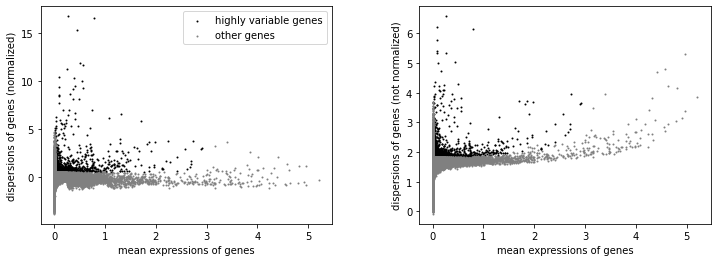

In [29]:
# find highly variable genes
sc.pp.highly_variable_genes(adata, min_mean = 0.0125, max_mean = 3, min_disp = 0.5)
sc.pl.highly_variable_genes(adata)

In [30]:
import multiprocessing
# subset to highly variable
adata = adata[:, adata.var['highly_variable']]
# regress and scale for PCA
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'], n_jobs=multiprocessing.cpu_count()-1)
sc.pp.scale(adata, max_value = 10)

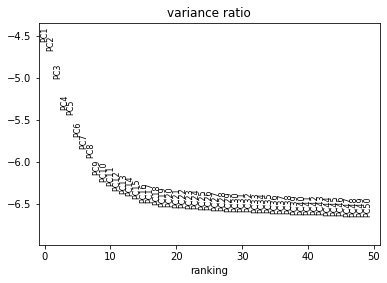

In [31]:
# Principal component analysis
sc.tl.pca(adata, svd_solver = 'arpack')
sc.pl.pca_variance_ratio(adata, log = True, n_pcs = 50)

In [32]:
# run BBKNN
sc.external.pp.bbknn(adata, batch_key = 'patient')

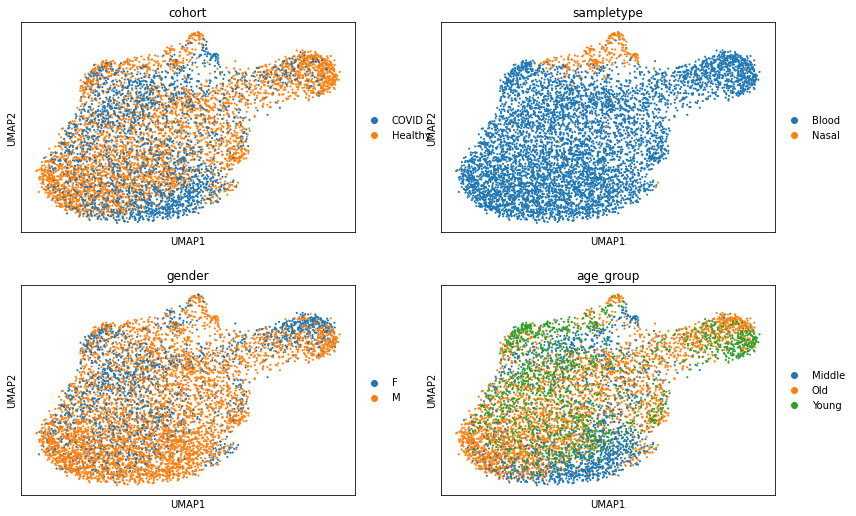

In [33]:
# UMAP
sc.tl.umap(adata, n_components = 2, min_dist = 0.3)
sc.pl.umap(adata, color=['cohort', 'sampletype', 'gender', 'age_group'], ncols =2)

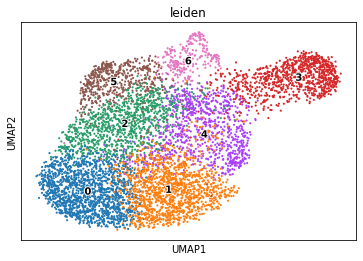

In [35]:
# run clustering
sc.tl.leiden(adata, resolution = 1)
sc.pl.umap(adata, color=['leiden'], legend_loc = 'on data', legend_fontoutline = 2, color_map = cmp())

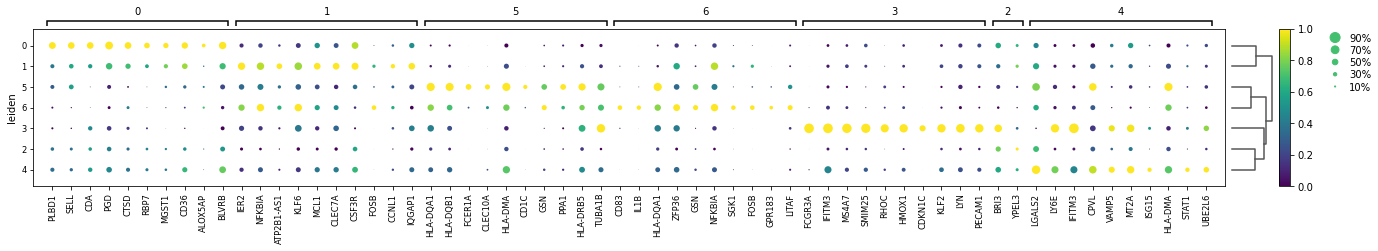

In [35]:
sc.tl.rank_genes_groups(adata, groupby = 'leiden', method = 'wilcoxon')
sc.tl.filter_rank_genes_groups(adata, min_fold_change=1)
sc.tl.dendrogram(adata, groupby = 'leiden')
sc.pl.rank_genes_groups_dotplot(adata, n_genes = 10, standard_scale = 'var', color_map = 'viridis', key = 'rank_genes_groups_filtered')

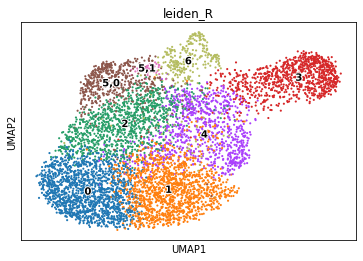

In [60]:
sc.tl.leiden(adata, resolution = .3, restrict_to = ('leiden', ['5']))
sc.pl.umap(adata, color=['leiden_R'], legend_loc = 'on data', legend_fontoutline = 2)

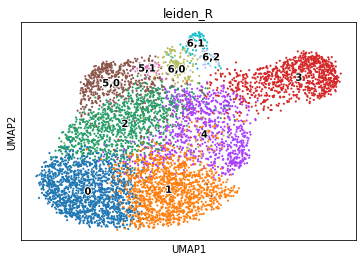

In [61]:
sc.tl.leiden(adata, resolution = .3, restrict_to = ('leiden_R', ['6']))
sc.pl.umap(adata, color=['leiden_R'], legend_loc = 'on data', legend_fontoutline = 2)

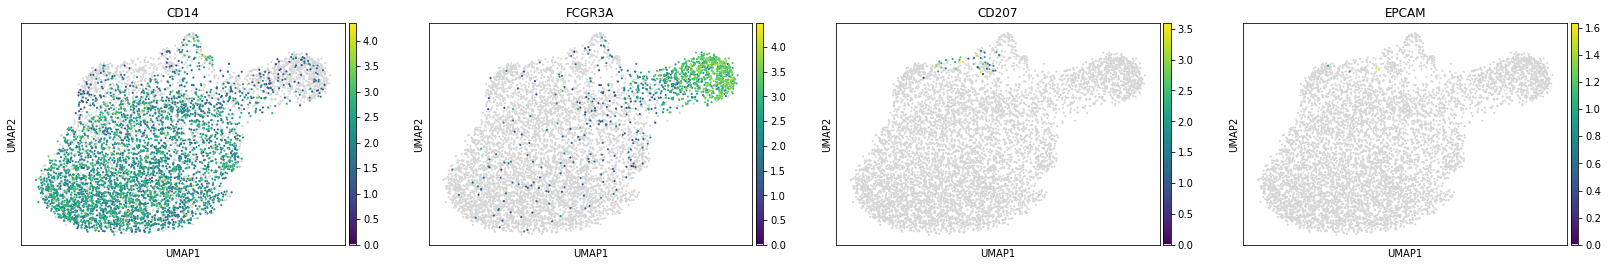

In [62]:
sc.pl.umap(adata, color=['CD14', 'FCGR3A', 'CD207', 'EPCAM'], color_map = cmp())

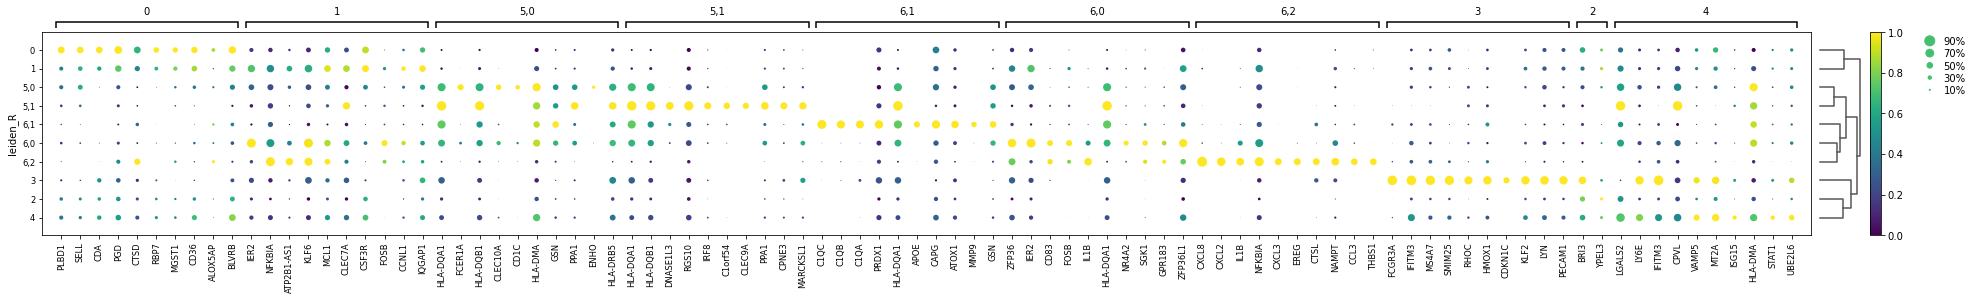

In [63]:
sc.tl.rank_genes_groups(adata, groupby = 'leiden_R', method = 'wilcoxon')
sc.tl.filter_rank_genes_groups(adata, min_fold_change=1)
sc.tl.dendrogram(adata, groupby = 'leiden_R')
sc.pl.rank_genes_groups_dotplot(adata, n_genes = 10, standard_scale = 'var', color_map = 'viridis', key = 'rank_genes_groups_filtered')

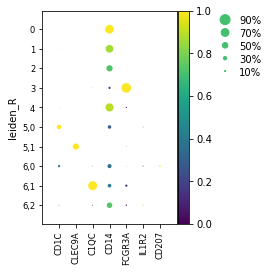

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[2.4499999999999997, 0, 0.2, 0.5, 0.25])

In [64]:
sc.pl.dotplot(adata, ['CD1C', 'CLEC9A', 'C1QC', 'CD14', 'FCGR3A', 'IL1R2', 'CD207'], color_map = 'viridis', groupby = 'leiden_R', standard_scale = 'var')

In [50]:
macrophage_signature = {'YS':['MMP9', 'CADM1', 'IRAK1', 'SH3YL1', 'DNAJB6', 'EPCAM', 'ECD', 'PFKP', 'FABP4', 'MS4A7', 'DCAKD', 'GPS1', 'TRNAU1AP', 'AGPAT3', 'DNAJB6', 'GPS1', 'SAE1', 'FOSB', 'HOXC4', 'FOLR2', 'GPS1', 'BAZ1B', 'OST4', 'PTPRA', 'PLOD1', 'PHF5A', 'NMD3', 'PLAU', 'CDK2', 'MAPK9', 'GDPD1', 'FBXO30', 'TRNAU1AP', 'MRC1', 'FAM98B', 'CCDC18', 'ANLN', 'CTBP2', 'ACSM3', 'S1PR1', 'PXDN', 'MAN1A1', 'COX6A1', 'SLC43A3', 'CCDC47', 'TNS3', 'PLEKHG5', 'NDUFS4', 'UBE2Z', 'B3GALNT1', 'TBC1D19', 'MRTO4', 'TRAIP', 'CEP55', 'UTP20', 'STMN1', 'STAB1', 'SMARCAD1', 'CTSB', 'MAN2B2', 'PTN', 'SLC30A7', 'LHFPL2', 'RALGDS', 'ABCB8', 'NDRG3', 'PEG3', 'NUF2', 'SENP5', 'SLC35D1', 'RILPL1', 'NDUFV1', 'AHSA1'],
'HSC':[' TTLL3', 'GDA', 'GPR35', 'IFITM2', 'XDH', 'CD74', 'MBP', 'S100A8', 'F12', 'PID1', 'CCR2', 'LILRA4', 'PNRC1', 'ARHGEF37', 'UBP1', 'TREML4', 'POLR1E', 'CYTIP', 'TEAD1', 'GZF1', 'PLAC8', 'RASGRP4', 'KLF13', 'PLBD1', 'MPG', 'DENND1C', 'SMPDL3A', 'DGKG', 'AL121845.2', 'PTHLH', 'AHNAK', 'KYNU', 'RAC2', 'AC069257.4', 'SELL']}

In [41]:
for s in macrophage_signature:
    sc.tl.score_genes(adata, macrophage_signature[s], use_raw = True, score_name= str(s)+'_score')

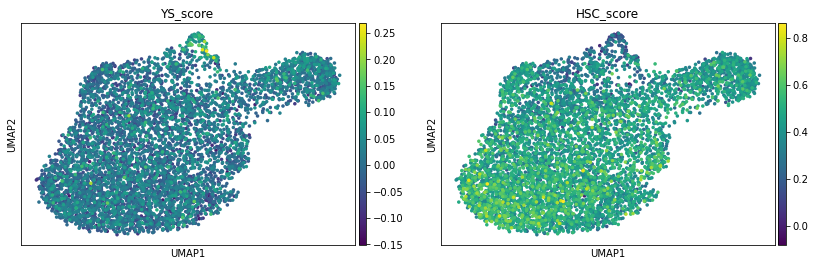

In [42]:
sc.pl.umap(adata, color=['YS_score', 'HSC_score'], size = 50, color_map = 'viridis')

In [51]:
def geneset_score(self, genesets, groupby, figsize=(3, 4), cmap = 'Blues'):
    import seaborn as sns
    for s in genesets:
        sc.tl.score_genes(self, genesets[s], use_raw = True, score_name= str(s)+'_score')
    # calculate average enrichment score
    list1 = list(set(self.obs[groupby]))
    subset = self.obs[[groupby] + [str(s)+'_score' for s in genesets]]
    output = pd.DataFrame()
    for x in list1:
        subsetX = subset[subset[groupby] == x]
        outdict = {}
        for k in [str(s)+'_score' for s in genesets]:
            out = {k:np.mean(subsetX[k])}
            outdict.update(out)
        output = output.append(outdict, ignore_index=True)
    output.index = list1
    output = output[[str(s)+'_score' for s in genesets]]
    g = sns.clustermap(output.transpose(), standard_scale = 0, cmap=cmap, figsize=figsize, col_cluster = False, row_cluster = False)
    print(g)

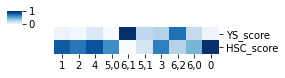

In [66]:
geneset_score(adata, macrophage_signature, 'leiden_R', (4,1))

... storing 'fine_label' as categorical


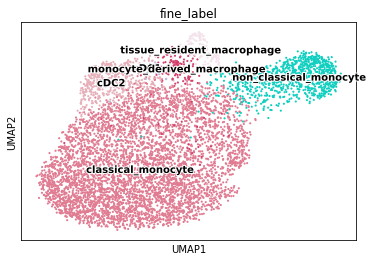

... storing 'fine_label' as categorical


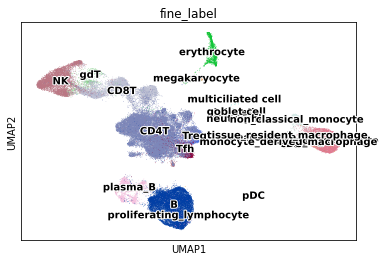

In [69]:
new_dict1 = {'0':'classical_monocyte',
'1':'classical_monocyte',
'2':'classical_monocyte',
'4':'classical_monocyte',
'3':'non_classical_monocyte',
'5,0':'cDC2',
'5,1':'cDC1',
'6,0':'monocyte_derived_macrophage',
'6,1':'tissue_resident_macrophage',
'6,2':'tissue_resident_macrophage'}
adata.obs['fine_label'] = [new_dict1[l] for l in adata.obs['leiden_R']]
adata_all.obs['fine_label'] = adata_all.obs['fine_label'].astype('object')
adata_all.obs['fine_label'].update(adata.obs['fine_label'].astype('object'))
sc.pl.umap(adata, color=['fine_label'], legend_loc ='on data', legend_fontoutline=2)
sc.pl.umap(adata_all, color=['fine_label'], legend_loc ='on data', legend_fontoutline=2)

In [71]:
outpath='out/DEG/MNP/'
if not os.path.exists(outpath):
    os.makedirs(outpath)
for i in list(set(adata.obs['fine_label'])):
    adatax = adata[adata.obs['fine_label'] == i]
    sc.tl.rank_genes_groups(adatax, groupby = 'cohort', method = 'wilcoxon', n_genes=30000)
    sc.tl.filter_rank_genes_groups(adatax, min_fold_change=1, max_out_group_fraction=1)
    exportDEres(adatax, 'rank_genes_groups', 'COVID', outpath+str(i)+'_COVID_vs_healthy.txt')

Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.


In [72]:
# save the MNP and all data set as is
adata.write('out/adata_mnp.h5ad', compression = 'gzip')
adata_all.write('out/adata_combined.h5ad', compression = 'gzip')

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import os
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata
import dandelion as ddl
import sys
sys.path.append('/home/jovyan/NC_study/scanpy/scripts')
from tools import cmp, exportDEres
sc.logging.print_versions()

warnings.filterwarnings('ignore')
os.chdir(os.path.expanduser('/home/jovyan/NC_study/scanpy'))

scanpy==1.5.1 anndata==0.7.4 umap==0.4.6 numpy==1.19.1 scipy==1.5.1 pandas==1.0.5 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.8.2 leidenalg==0.8.1


In [2]:
adata = sc.read_h5ad('out/adata_mnp.h5ad')
adata

AnnData object with n_obs × n_vars = 6595 × 1819
    obs: 'sampleid', 'patient', 'sampletype', 'age_group', 'gender', 'cohort', 'scrublet_score', 'n_genes', 'percent_mito', 'n_counts', 'bh_pval', 'is_doublet', 'filter_rna', 'batch', 'leiden', '__is_in_cluster__', 'fine_label', 'broad_label', 'leiden_R', 'leiden_label', 'YS_score', 'HSC_score'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'age_group_colors', 'broad_label_colors', 'cohort_colors', 'dendrogram_leiden', 'dendrogram_leiden_R', 'fine_label_colors', 'gender_colors', 'leiden', 'leiden_R_colors', 'leiden_colors', 'leiden_label_colors', 'neighbors', 'patient_colors', 'pca', 'rank_genes_groups', 'rank_genes_groups_filtered', 'sampletype_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [3]:
# reorder the categories
adata.obs['fine_label'] = adata.obs['fine_label'].cat.reorder_categories(['cDC1', 
                                                'cDC2', 
                                                'classical_monocyte',
                                                'non_classical_monocyte', 
                                                'monocyte_derived_macrophage',
                                                'tissue_resident_macrophage'])

### Setting up some colours

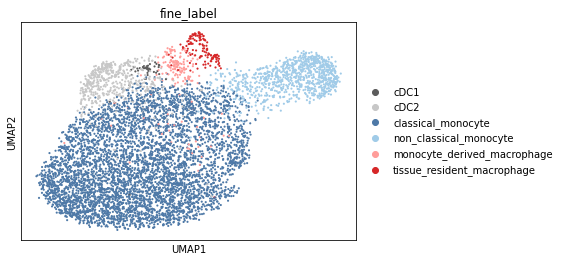

In [4]:
sc.pl.umap(adata, color = 'fine_label', palette = ['#5c5c5c','#c7c7c7', # cDC1, cDC2
                                                   '#4e79a7','#a0cbe8', # classical, non-classical
                                                   '#ff9d9a','#d62728']) # monocyte, tissue-res

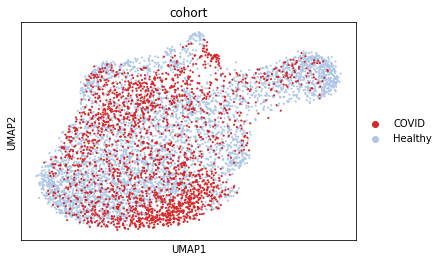

In [5]:
sc.pl.umap(adata, color = 'cohort', palette = ['#d62728', '#aec7e8'])

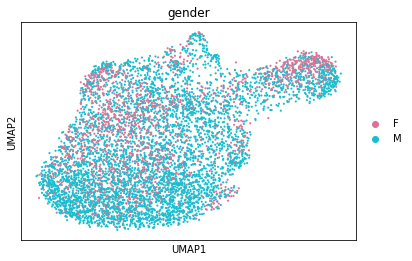

In [6]:
sc.pl.umap(adata, color = 'gender', palette = ['#dc7295','#17becf'])

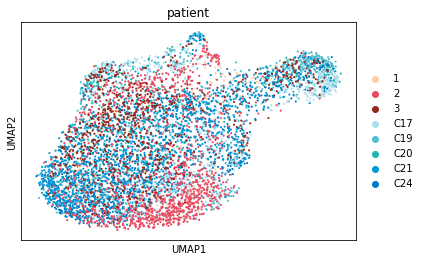

In [7]:
sc.pl.umap(adata, color = 'patient', palette = ['#FECEA8' ,'#E84A5F' ,'#96281B' ,'#AFDFEF' ,'#54BCD1' ,'#1BB6AF' ,'#0099D5' ,'#007BC3', '#172869'])

In [8]:
adata.write('out/adata_mnp.h5ad', compression = 'gzip')
adata

AnnData object with n_obs × n_vars = 6595 × 1819
    obs: 'sampleid', 'patient', 'sampletype', 'age_group', 'gender', 'cohort', 'scrublet_score', 'n_genes', 'percent_mito', 'n_counts', 'bh_pval', 'is_doublet', 'filter_rna', 'batch', 'leiden', '__is_in_cluster__', 'fine_label', 'broad_label', 'leiden_R', 'leiden_label', 'YS_score', 'HSC_score'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'age_group_colors', 'broad_label_colors', 'cohort_colors', 'dendrogram_leiden', 'dendrogram_leiden_R', 'fine_label_colors', 'gender_colors', 'leiden', 'leiden_R_colors', 'leiden_colors', 'leiden_label_colors', 'neighbors', 'patient_colors', 'pca', 'rank_genes_groups', 'rank_genes_groups_filtered', 'sampletype_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

### Generating DEG list for MNPs COVID versus Healthy

In [5]:
outpath='out/DEG/MNP/'
if not os.path.exists(outpath):
    os.makedirs(outpath)
for i in list(set(adata.obs['fine_label'])):
    adatax = adata[adata.obs['fine_label'] == i]
    sc.tl.rank_genes_groups(adatax, groupby = 'cohort', method = 'wilcoxon', n_genes=30000)
    sc.tl.filter_rank_genes_groups(adatax, min_fold_change=[-1,1], max_out_group_fraction=1)
    exportDEres(adatax, 'rank_genes_groups', 'COVID', outpath+str(i)+'_COVID_vs_healthy.txt')
    exportDEres(adatax, 'rank_genes_groups_filtered', 'COVID', outpath+str(i)+'_COVID_vs_healthy_filtered.txt')

Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.


### Stacked violin plots for some interesting markers

... storing 'cohort_finelabel' as categorical


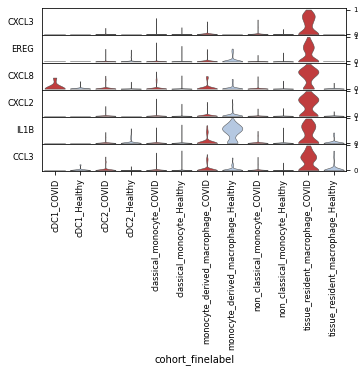

[<AxesSubplot:ylabel='CXCL3'>,
 <AxesSubplot:ylabel='EREG'>,
 <AxesSubplot:ylabel='CXCL8'>,
 <AxesSubplot:ylabel='CXCL2'>,
 <AxesSubplot:ylabel='IL1B'>,
 <AxesSubplot:xlabel='cohort_finelabel', ylabel='CCL3'>]

In [11]:
adata.obs['cohort_finelabel'] = [l +'_' +c for l, c in zip(adata.obs['fine_label'], adata.obs['cohort'])]
sc.pl.stacked_violin(adata, ['CXCL3', 'EREG', 'CXCL8', 'CXCL2', 'IL1B', 'CCL3'], 
                     groupby = 'cohort_finelabel', 
                     standard_scale = 'var', 
                     palette = adata.uns['cohort_colors'],
                     swap_axes = True,
                     figsize = (6,3))

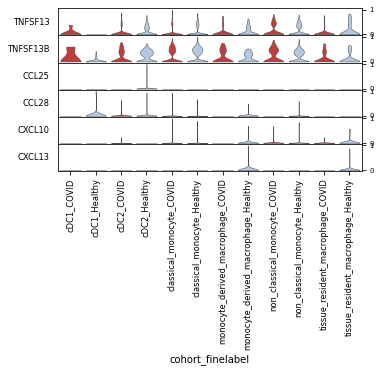

[<AxesSubplot:ylabel='TNFSF13'>,
 <AxesSubplot:ylabel='TNFSF13B'>,
 <AxesSubplot:ylabel='CCL25'>,
 <AxesSubplot:ylabel='CCL28'>,
 <AxesSubplot:ylabel='CXCL10'>,
 <AxesSubplot:xlabel='cohort_finelabel', ylabel='CXCL13'>]

In [12]:
sc.pl.stacked_violin(adata, ['TNFSF13', 'TNFSF13B', 'CCL25', 'CCL28', 'CXCL10', 'CXCL13'], 
                     groupby = 'cohort_finelabel', 
                     standard_scale = 'var', 
                     palette = adata.uns['cohort_colors'],
                     swap_axes = True,
                     figsize = (6,3))

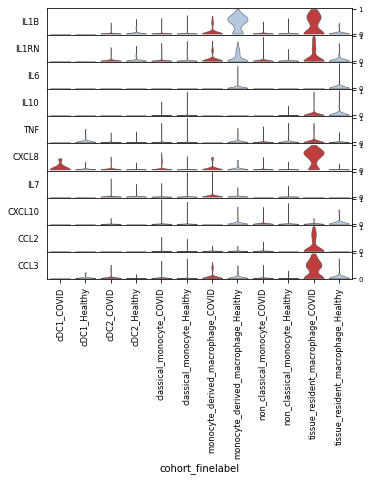

[<AxesSubplot:ylabel='IL1B'>,
 <AxesSubplot:ylabel='IL1RN'>,
 <AxesSubplot:ylabel='IL6'>,
 <AxesSubplot:ylabel='IL10'>,
 <AxesSubplot:ylabel='TNF'>,
 <AxesSubplot:ylabel='CXCL8'>,
 <AxesSubplot:ylabel='IL7'>,
 <AxesSubplot:ylabel='CXCL10'>,
 <AxesSubplot:ylabel='CCL2'>,
 <AxesSubplot:xlabel='cohort_finelabel', ylabel='CCL3'>]

In [13]:
sc.pl.stacked_violin(adata, ['IL1B', 'IL1RN', 'IL6', 'IL10', 'TNF', 'CXCL8', 'IL7', 'CXCL10', 'CCL2', 'CCL3'], 
                     groupby = 'cohort_finelabel', 
                     standard_scale = 'var', 
                     palette = adata.uns['cohort_colors'],
                     swap_axes = True,
                     figsize = (6,5))

... storing 'cohort_finelabel' as categorical


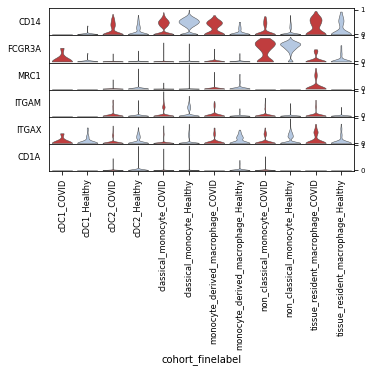

[<AxesSubplot:ylabel='CD14'>,
 <AxesSubplot:ylabel='FCGR3A'>,
 <AxesSubplot:ylabel='MRC1'>,
 <AxesSubplot:ylabel='ITGAM'>,
 <AxesSubplot:ylabel='ITGAX'>,
 <AxesSubplot:xlabel='cohort_finelabel', ylabel='CD1A'>]

In [14]:
adata.obs['cohort_finelabel'] = [l +'_' +c for l, c in zip(adata.obs['fine_label'], adata.obs['cohort'])]
sc.pl.stacked_violin(adata, ['CD14', 'FCGR3A', 'MRC1', 'ITGAM', 'ITGAX', 'CD1A'], 
                     groupby = 'cohort_finelabel', 
                     standard_scale = 'var', 
                     palette = ['#d62728', '#aec7e8'],
                     swap_axes = True,
                     figsize = (6,3))